# Synthetic Dose-Response Generator 


In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sbn 
import datetime
from DR_generator import *
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

# Model Description

This generator assumes hermetic curves start high (cell viab probabilty = 1) then follow a logisitic shape during the inhibitory period followed a refractory/hormetic region wherin the curve shape is assumed to be linearly increasing.

---

The model parameters of inhibitory and hermetic regions are (pseudo) randomly sampled from the parameter ranges the user provides. To build a good intuition for logistic regression parameter [choices](http://mathworld.wolfram.com/LogisticEquation.html). 

## Inhibitory region model: Logisitic/Sigmoid

$$ P_i(c) = \frac{1}{1+e^{-(b0 + b1*c)}} $$ 

where,  
    c = concentration  
    b0 = intercept parameter  
    b1 = slope parameter  

## Hermetic region model: linear increasing

$$ P_h(c) = m*c + b $$

for $p_h(c) < 1 $ and $p_h(c) = 1 $ otherwise. 

where,  
    m = slope > 0  
    c = concentration   
    b = y intercept  

## Full model

We expect there to be both biological and measurement variation which we will model as a Gaussian distribution. The overall piecewise probability function is:

P(c) = N(u, s)  
    where,  
        s = sampling std (user defined)  
        u = distribution mean, centered at:  
            $ P_i(c) $ for 0 <= c <= t  
            $ P_h(c) $ for t <= c < max_dose  
                where,  
                    t = transition point  

we also expect our equation to be discrete continuous (we are pulling only 7 points at discrete concentration points from these models) such that:  

$P_i(t)$ = $P_h(t)$  

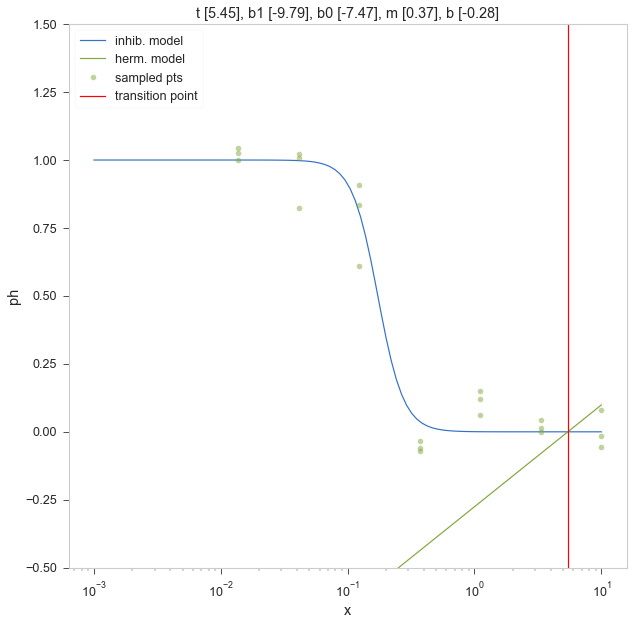

,t,b1,b0,m,b,s,DOSE_10.00,DOSE_3.33,DOSE_1.11,DOSE_0.37,DOSE_0.12,DOSE_0.04,DOSE_0.01,id
0,5.445364,-9.792481,-7.465407,0.374402,-0.275569,0.1,-0.055708,-0.000835,0.062499,-0.034367,0.833595,1.008624,1.000408,623548808295825851
1,5.445364,-9.792481,-7.465407,0.374402,-0.275569,0.1,0.081372,0.043306,0.120669,-0.058865,0.909871,1.020632,1.044493,1464376379350217304
2,5.445364,-9.792481,-7.465407,0.374402,-0.275569,0.1,-0.014828,0.013517,0.148819,-0.070339,0.609271,0.823432,1.026586,616790113919347833


In [18]:
'''
s              <float>            standard deviation for gaussian noise model
dose_points    <list>             the concentration points to sample at. First value should always be zero.
mrange         <tuple, floats>    must be positive, allowed range of values to choose for m in the hermetic model
b0range        <tuple, float>     range of acceptable b0's to sample from
trange         <tuple, float>     range of transition point to sample from, neither value can be zero (sampled in logspace)
n              <int>              number of independant dose-response models to sample from
nn             <int>              number replicates to draw at each dose
'''
np.random.seed(10)
mygen = hermetic_generator(s = 0.05, b1range=(-10, 0), mrange= (0,0.5), b0range=(-10,-6), trange=(1,9), dose_points = [10/(3**i) for i in range(0,7)])
syn_data = mygen.get(n=1, nn=3, plot=True)
syn_data.head()

# Data Batches 

If you want to create batches of data, all with different parameter ranges, the code may help.

In [6]:
batch_size = 10
starting_noise = 0.01
noise_range = [5*5**-x for x in np.arange(1.5,6, 0.5)]
save_to_disk = False

mygen = hermetic_generator(s = starting_noise, b1range=(-10, 0), mrange= (0,0.5), b0range=(-10,-6), trange=(0.001,15), dose_points = [10/(3**i) for i in range(0,7)])
syn_data = mygen.get(n=batch_size, nn=1, plot=False)

for i, noise in enumerate(noise_range):
    print('batch: %d [noise=%f]' %(i+1, noise), end='\r')
    mygen2 = hermetic_generator(s = noise, b1range=(-10, 0), mrange= (0,0.5), b0range=(-10,-6), trange=(0.001,15), dose_points = [10/(3**i) for i in range(0,7)])
    syn_data = syn_data.append(mygen2.get(n=batch_size, nn=1, plot=False), ignore_index=True, sort=False)
    
if save_to_disk: syn_data.to_csv('./data/performance_analysis_set.csv')

print()
print('dataset size: %s' %str(syn_data.shape), end='\r')

batch: 9 [noise=0.000716]
